# **Intro to Langraph**

### **Overview**

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.


#### **Key Features**

- **Cycles and Branching:** Implement loops and conditionals in your apps.
- **Persistence:** Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- **Human-in-the-Loop:** Interrupt graph execution to approve or edit next action planned by the agent.
- **Streaming Support:** Stream outputs as they are produced by each node (including token streaming).

**Next, add a `"chatbot"` node.**

Nodes represent units of work. 

They are typically regular python functions.

## Let's Build Something!

Here, we will build a chatbot in LangGraph that can:

✅ Answer common questions by searching the web

✅ Maintain conversation state across calls

✅ Route complex queries to a human for review

✅ Use custom state to control its behavior

✅ Rewind and explore alternative conversation paths


We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way. 


**Let’s dive in!** 🌟

## Setup Ollama

In [ ]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="llama3.2")

llm.invoke("The first man on the moon was ...")

'...Neil Armstrong. He stepped onto the lunar surface on July 20, 1969, during the Apollo 11 mission.'

In [ ]:
from langchain_ollama import ChatOllama

chat_model = ChatOllama(model="llama3.2")

chat_model.invoke("Who was the first man on the moon?")

AIMessage(content='Neil Armstrong was the first man to set foot on the moon. He stepped out of the lunar module Eagle and onto the moon\'s surface on July 20, 1969, during the Apollo 11 mission. Armstrong famously declared, "That\'s one small step for man, one giant leap for mankind," as he became the first person to walk on the moon.', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-11-26T20:37:37.205426Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1075182459, 'load_duration': 29646250, 'prompt_eval_count': 34, 'prompt_eval_duration': 190000000, 'eval_count': 75, 'eval_duration': 854000000}, id='run-c556c8d4-8c1a-4525-bf35-38f57c47de3f-0', usage_metadata={'input_tokens': 34, 'output_tokens': 75, 'total_tokens': 109})

In [ ]:
response = chat_model.invoke("Who was the first man on the moon?")

response.content

'The first man to walk on the Moon was Neil Armstrong. He stepped out of the lunar module Eagle and onto the Moon\'s surface on July 20, 1969, during the Apollo 11 mission. His famous words upon setting foot on the Moon were: "That\'s one small step for man, one giant leap for mankind."'

In [ ]:
response.usage_metadata

{'input_tokens': 34, 'output_tokens': 69, 'total_tokens': 103}

In [ ]:
chat_model.invoke("The first man on the moon was ...")

AIMessage(content='...Neil Armstrong. He stepped out of the lunar module Eagle and onto the Moon\'s surface on July 20, 1969, during the Apollo 11 mission. His famous words upon setting foot on the Moon were: "That\'s one small step for man, one giant leap for mankind."', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-11-18T06:06:14.198208Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 922350250, 'load_duration': 34709167, 'prompt_eval_count': 33, 'prompt_eval_duration': 231000000, 'eval_count': 61, 'eval_duration': 655000000}, id='run-b8381199-11f0-4eef-964e-a7f31982be2b-0', usage_metadata={'input_tokens': 33, 'output_tokens': 61, 'total_tokens': 94})

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. 

Though simple, it will illustrate the core concepts of building with LangGraph. 

By the end of this section, you will have a built rudimentary chatbot.


**Start by creating a StateGraph.**

A StateGraph object defines the structure of our chatbot as a "state machine". 

We'll add nodes to represent the llm and functions our chatbot can call and edges 

to specify how the bot should transition between these functions.

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Our graph can now handle two key tasks:**

1. Each node can receive the current State as input and output an update to the state.
2. Updates to messages will be appended to the existing list rather than overwriting it, 
    
    thanks to the prebuilt `add_messages` function used with the Annotated syntax.


**Next, add a `"chatbot"` node.**

Nodes represent units of work. 

They are typically regular python functions.

In [ ]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notes** 

The chatbot node function takes the current State as input and 

**returns a dictionary** containing an updated messages list under the key `"messages"`. 

This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our State will append the llm's response messages to whatever messages are already in the state.

**Next, add an entry point. This tells our graph where to start its work each time we run it.**

In [ ]:
graph_builder.add_edge(START, "chatbot")

**Similarly, set a finish point.**

This instructs the graph "any time this node is run, you can exit."

In [ ]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. 


This creates a "CompiledGraph" we can use invoke on our state.

In [ ]:
graph = graph_builder.compile()

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. 


The draw methods each require additional dependencies.

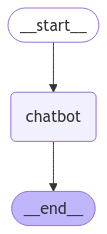

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I am a large language model, specifically a variant of the LLaMA (Large Language Model Application) architecture. LLaMA is an open-source language model developed by Meta AI, designed to handle natural language processing tasks such as text generation, question-answering, and conversation.

My specific model is based on a transformer architecture, which is a type of neural network that has become popular in recent years for its ability to process sequential data. The LLaMA model uses this architecture to generate human-like text responses to user input.

Here are some key characteristics of my LLaMA-based model:

1. **Model size**: My model is based on the larger LLaMA model, which has a large number of parameters (around 300 million) and is trained on a massive dataset of text from various sources.
2. **Training data**: I was trained on a large corpus of text data, including books, articles, and conversations, to learn patterns and relationships in language.
3. **Neural net

Congratulations! You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. 

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

Below is the full code for this section for your reference:

### Full Code

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_ollama import ChatOllama


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.2")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()


# from IPython.display import Image, display

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass



def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break